## Import Necessary Libraries

In [1]:
import pandas as pd
from xgboost import XGBClassifier
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [13]:
!pip install xgboost --user

## Parse and Preprocess the Logs

In [23]:
import re
import pandas as pd

def remove_ansi_codes(log_line):
    # Remove ANSI escape sequences
    return re.sub(r'\x1b\[[0-9;]*[a-zA-Z]', '', log_line)

def parse_logs_fixed(log_files):
    data = []
    for file in log_files:
        print(f"Processing file: {file}")
        with open(file, 'r') as f:
            for line in f:
                # Remove ANSI escape codes
                cleaned_line = remove_ansi_codes(line)
                
                # Extract relevant fields
                timestamp = re.search(r"\[\d{8}\s+\d{2}:\d{2}:\d{2}\]", cleaned_line)
                service = re.search(r"\]\s+(\w+)", cleaned_line)  # Service is the first word after timestamp
                message = re.search(r"(/dionaea/.*)", cleaned_line)

                # Append extracted data if all fields are present
                if timestamp and service and message:
                    data.append({
                        "timestamp": timestamp.group(0).strip("[]"),
                        "service": service.group(1),
                        "message": message.group(1)
                    })
    return pd.DataFrame(data)

# Parse the logs
log_files = ["log1.txt", "log2.txt", "log3.txt"]
df = parse_logs_fixed(log_files)
print(df.head())


Processing file: log1.txt
Processing file: log2.txt
Processing file: log3.txt
           timestamp   service  \
0  25012025 05:22:03      pptp   
1  25012025 05:22:03  services   
2  25012025 05:22:03      pptp   
3  25012025 05:22:03  services   
4  25012025 05:22:58      http   

                                             message  
0  /dionaea/pptp/pptp.py:52: No config provided. ...  
1   /dionaea/services.py:46: Unable to start service  
2  /dionaea/pptp/pptp.py:52: No config provided. ...  
3   /dionaea/services.py:46: Unable to start service  
4  /dionaea/http.py:133: max_num_fields is only s...  


## Label the Data

In [24]:
# Function to label logs
def label_logs(df):
    def label(row):
        service = row['service'].lower()
        message = row['message'].lower()

        if 'http' in service or 'http' in message:
            if 'sql' in message or 'injection' in message:
                return 'SQL Injection'
            elif 'xss' in message or 'script' in message:
                return 'Cross-Site Scripting'
            else:
                return 'HTTP Attack'
        elif 'ftp' in service or 'ftp' in message:
            return 'FTP Attack'
        elif 'sip' in service or 'pptp' in service or 'pptp' in message:
            return 'SIP Attack'
        elif 'ssh' in service or 'brute' in message:
            return 'SSH Attack'
        elif 'dns' in service or 'dns' in message:
            return 'DNS Attack'
        elif 'log_sqlite' in service or 'log_sqlite' in message:
            return 'Log_SQLite Attack'
        elif 'download' in message or 'malware' in message:
            return 'Malware Download'
        else:
            return 'Other Attack'
    
    df['attack_type'] = df.apply(label, axis=1)
    return df

# Apply labeling function
df_labeled = label_logs(df)

# Display labeled logs
print("Labeled Logs:")
print(df_labeled.head())


Labeled Logs:
           timestamp   service  \
0  25012025 05:22:03      pptp   
1  25012025 05:22:03  services   
2  25012025 05:22:03      pptp   
3  25012025 05:22:03  services   
4  25012025 05:22:58      http   

                                             message   attack_type  
0  /dionaea/pptp/pptp.py:52: No config provided. ...    SIP Attack  
1   /dionaea/services.py:46: Unable to start service  Other Attack  
2  /dionaea/pptp/pptp.py:52: No config provided. ...    SIP Attack  
3   /dionaea/services.py:46: Unable to start service  Other Attack  
4  /dionaea/http.py:133: max_num_fields is only s...   HTTP Attack  


In [25]:
df_labeled = label_logs(df)

# Check if 'log_sqlite' logs are labeled correctly
print(df_labeled[df_labeled['service'].str.contains('log_sqlite', case=False) | 
                 df_labeled['message'].str.contains('log_sqlite', case=False)])

              timestamp     service  \
5     25012025 05:22:58  log_sqlite   
58    25012025 05:25:55  log_sqlite   
87    25012025 05:27:10  log_sqlite   
88    25012025 05:27:10  log_sqlite   
89    25012025 05:27:10  log_sqlite   
...                 ...         ...   
6326  27012025 12:33:28  log_sqlite   
6330  27012025 13:00:07  log_sqlite   
6331  27012025 13:04:58  log_sqlite   
6334  27012025 13:30:58  log_sqlite   
6337  27012025 13:37:00  log_sqlite   

                                                message        attack_type  
5     /dionaea/logsql.py:747: no attackid for 172.17...  Log_SQLite Attack  
58    /dionaea/logsql.py:747: no attackid for 172.17...  Log_SQLite Attack  
87    /dionaea/logsql.py:747: no attackid for 172.17...  Log_SQLite Attack  
88    /dionaea/logsql.py:747: no attackid for 172.17...  Log_SQLite Attack  
89    /dionaea/logsql.py:747: no attackid for 172.17...  Log_SQLite Attack  
...                                                 ...              

## Prepare Data for Model Training

### Vectorize the message Column

In [26]:
# Vectorize the 'message' column
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_labeled['message']).toarray()


### Encode the attack_type Labels

In [27]:
# Encode the attack_type column
df_labeled['attack_type_encoded'] = df_labeled['attack_type'].factorize()[0]
y = df_labeled['attack_type_encoded']

### Split the Data into Training and Testing Sets

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train the Model Using XGBoost

In [29]:
# Initialize and train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

print("XGBoost Model Training Complete!")


C:\Users\hp\anaconda3\libs\New folder\lib\site-packages\xgboost\core.py:158: UserWarning: [11:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Training Complete!


### Evaluate the Model

In [30]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=df_labeled['attack_type'].unique()))


Accuracy: 1.0

Classification Report:
                    precision    recall  f1-score   support

       SIP Attack       1.00      1.00      1.00         2
     Other Attack       1.00      1.00      1.00        25
      HTTP Attack       1.00      1.00      1.00       505
Log_SQLite Attack       1.00      1.00      1.00       685
       FTP Attack       1.00      1.00      1.00        52

         accuracy                           1.00      1269
        macro avg       1.00      1.00      1.00      1269
     weighted avg       1.00      1.00      1.00      1269



### Save the Model and Vectorizer for Future Use

In [31]:
# Save the model and vectorizer
with open('xgboost_attack_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


## Predict Attack Types for a New Log File

### Load the Model and Vectorizer

In [5]:
# Load the saved model and vectorizer
with open('xgboost_attack_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)


C:\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Parse and Label the New Logs

In [3]:
# Parse new logs
new_log_files = ["logtest2.txt"]  # Replace with the path of the new log file
df_new = parse_logs_fixed(new_log_files)
df_new = label_logs(df_new)

# Vectorize the 'message' column of new logs
X_new = vectorizer.transform(df_new['message']).toarray()


NameError: name 'parse_logs_fixed' is not defined

### Predict Attack Types for New Logs

In [34]:
# Predict attack types for the new logs
y_new_pred = model.predict(X_new)

# Map encoded predictions back to attack type labels
attack_type_mapping = dict(enumerate(df_labeled['attack_type'].factorize()[1]))
df_new['predicted_attack_type'] = [attack_type_mapping[pred] for pred in y_new_pred]

# Display predictions
print("Predictions for New Logs:")
print(df_new[['timestamp', 'service', 'message', 'predicted_attack_type']])


Predictions for New Logs:
             timestamp     service  \
0    28012025 06:42:23        pptp   
1    28012025 06:42:23    services   
2    28012025 06:42:23        pptp   
3    28012025 06:42:23    services   
4    28012025 06:45:33         SMB   
..                 ...         ...   
635  30012025 01:33:52  log_sqlite   
636  30012025 01:33:53  log_sqlite   
637  30012025 01:33:53  log_sqlite   
638  30012025 01:33:53  log_sqlite   
639  30012025 01:37:08        http   

                                               message predicted_attack_type  
0    /dionaea/pptp/pptp.py:52: No config provided. ...            SIP Attack  
1     /dionaea/services.py:46: Unable to start service          Other Attack  
2    /dionaea/pptp/pptp.py:52: No config provided. ...            SIP Attack  
3     /dionaea/services.py:46: Unable to start service          Other Attack  
4    /dionaea/smb/smb.py:127: p.haslayer(Raw): b'PA...          Other Attack  
..                                         

### Save Predictions to a CSV File

In [35]:
# Save the predictions to a CSV file
df_new.to_csv("xgboost_predicted_new_logs.csv", index=False)
print("Predictions saved to xgboost_predicted_new_logs.csv")


Predictions saved to xgboost_predicted_new_logs.csv


## Heatmap Representation

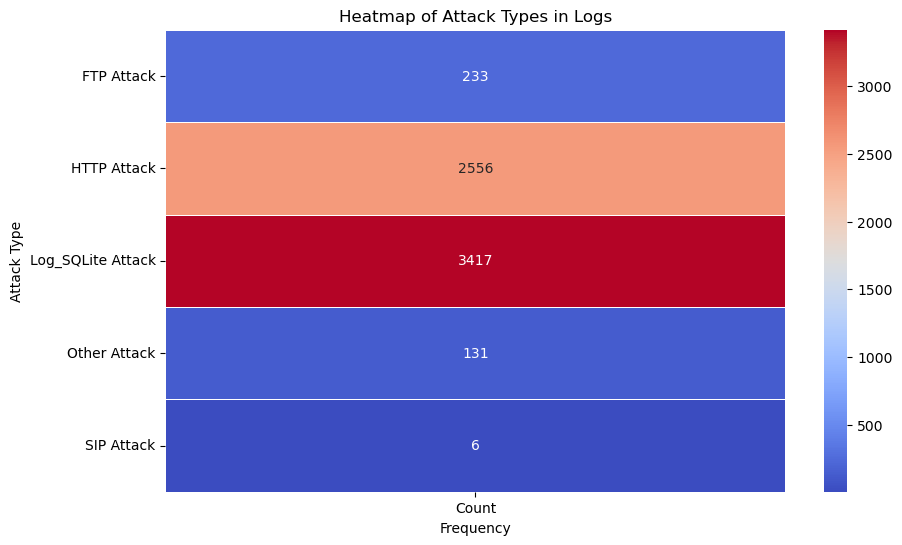

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the labeled logs dataset
df_labeled = pd.read_csv("labeled_logs.csv")  # Ensure this file exists

# Count the occurrences of each attack type
attack_counts = df_labeled['attack_type'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Count']

# Pivot the data to create a heatmap-friendly format
heatmap_data = attack_counts.pivot_table(index="Attack Type", values="Count")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)

# Customization
plt.title("Heatmap of Attack Types in Logs")
plt.xlabel("Frequency")
plt.ylabel("Attack Type")
plt.show()
